# QUESTION 3

**DATA LOADING**

In [2]:
import pandas as pd

# Load the parallel corpus
with open("/content/english-corpus.txt", "r", encoding="utf-8") as f:
    english_sentences = f.read().splitlines()

with open("/content/urdu-corpus.txt", "r", encoding="utf-8") as f:
    urdu_sentences = f.read().splitlines()

# Combine into DataFrame
df = pd.DataFrame({'English': english_sentences, 'Urdu': urdu_sentences})
df.head()


,English,Urdu
0,is zain your nephew,زین تمہارا بھتیجا ہے۔
1,i wish youd trust me,کاش تم مجھ پر بھروسہ کرتے
2,did he touch you,کیا اس نے آپ کو چھوا؟
3,its part of life,اس کی زندگی کا حصہ
4,zain isnt ugly,زین بدصورت نہیں ہے۔


**DATA PREPROCESSING**

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize English
en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(df['English'])
en_sequences = en_tokenizer.texts_to_sequences(df['English'])

# Tokenize Urdu
ur_tokenizer = Tokenizer()
ur_tokenizer.fit_on_texts(df['Urdu'])
ur_sequences = ur_tokenizer.texts_to_sequences(df['Urdu'])

# Vocabulary sizes
en_vocab_size = len(en_tokenizer.word_index) + 1
ur_vocab_size = len(ur_tokenizer.word_index) + 1

# Padding
MAX_LEN_EN = 20
MAX_LEN_UR = 20

en_padded = pad_sequences(en_sequences, maxlen=MAX_LEN_EN, padding='post')
ur_padded = pad_sequences(ur_sequences, maxlen=MAX_LEN_UR, padding='post')


**TEST AND TRAIN**

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(en_padded, ur_padded, test_size=0.1, random_state=42)

# Reshape y for sparse_categorical_crossentropy
y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)


**SIMPLE RNN**

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense

def build_rnn_seq2seq():
    # Encoder
    encoder_inputs = Input(shape=(MAX_LEN_EN,))
    encoder_embedding = Embedding(en_vocab_size, 128)(encoder_inputs)
    encoder_output, state = SimpleRNN(128, return_state=True)(encoder_embedding)


    # Decoder
    decoder_inputs = Input(shape=(MAX_LEN_UR,))
    decoder_embedding = Embedding(ur_vocab_size, 128)(decoder_inputs)
    decoder_output = SimpleRNN(128, return_sequences=True)(decoder_embedding, initial_state=state)
    outputs = Dense(ur_vocab_size, activation='softmax')(decoder_output)

    model = Model([encoder_inputs, decoder_inputs], outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

rnn_model = build_rnn_seq2seq()
rnn_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 20, 128)   │    726,912 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 20, 128)   │    759,040 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn          │ [(None, 128),     │     32,896 │ embedding[0][0]   │
│ (SimpleRNN)         │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_1        │ (None, 20, 128)   │     32,896 │ embedding_1[0][0… │
│ (SimpleRNN)         │                   │            │ simple_rnn[0][1]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 20, 5930)  │    764,970 │ simple_rnn_1[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,316,714 (8.84 MB)

 Trainable params: 2,316,714 (8.84 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Prepare decoder input and target (shifted version of urdu padded sequences)
decoder_input_data = y_train[:, :-1]
decoder_input_data = pad_sequences(decoder_input_data, maxlen=MAX_LEN_UR, padding='post')

decoder_target_data = y_train[:, 1:]
decoder_target_data = pad_sequences(decoder_target_data, maxlen=MAX_LEN_UR, padding='post')

# Train the model (RNN model already defined as rnn_model)
history_rnn = rnn_model.fit(
    [X_train, decoder_input_data],  # encoder input and decoder input
    decoder_target_data,            # decoder output (target)
    epochs=50,
    batch_size=64,
    validation_split=0.1
)


Epoch 1/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.7702 - loss: 2.9670 - val_accuracy: 0.8078 - val_loss: 1.2237
Epoch 2/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8139 - loss: 1.1717 - val_accuracy: 0.8202 - val_loss: 1.1280
Epoch 3/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8239 - loss: 1.0693 - val_accuracy: 0.8289 - val_loss: 1.0553
Epoch 4/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8327 - loss: 0.9874 - val_accuracy: 0.8346 - val_loss: 1.0070
Epoch 5/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8420 - loss: 0.9102 - val_accuracy: 0.8392 - val_loss: 0.9712
Epoch 6/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8470 - loss: 0.8591 - val_accuracy: 0.8420 - val_loss: 0.9492
Epoch 7/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8524 - loss: 0.8134 - val_accuracy: 0.8440 - val_loss: 0.9343
Epoch 8/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8547 - loss: 0.7811 - val_acc

**BIDIRECTIONAL RNN**

In [7]:
from tensorflow.keras.layers import Bidirectional, LSTM

def build_birnn_seq2seq():
    # Encoder
    encoder_inputs = Input(shape=(MAX_LEN_EN,))
    encoder_embedding = Embedding(en_vocab_size, 128)(encoder_inputs)

    # Use Bidirectional LSTM for the encoder
    encoder_output, forward_state, backward_state, forward_cstate, backward_cstate = Bidirectional(LSTM(128, return_state=True))(encoder_embedding)
    state = [forward_state, backward_state]  # We need both forward and backward states

    # Decoder
    decoder_inputs = Input(shape=(MAX_LEN_UR,))
    decoder_embedding = Embedding(ur_vocab_size, 128)(decoder_inputs)
    decoder_output = LSTM(128, return_sequences=True)(decoder_embedding, initial_state=state)
    outputs = Dense(ur_vocab_size, activation='softmax')(decoder_output)

    model = Model([encoder_inputs, decoder_inputs], outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and summarize the BiRNN model
rnn_model_birnn = build_birnn_seq2seq()
rnn_model_birnn.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 20, 128)   │    726,912 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 20, 128)   │    759,040 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 256),     │    263,168 │ embedding_2[0][0] │
│ (Bidirectional)     │ (None, 128),      │            │                   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 20, 128)   │    131,584 │ embedding_3[0][0… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 20, 5930)  │    764,970 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,645,674 (10.09 MB)

 Trainable params: 2,645,674 (10.09 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Prepare decoder input and target (shifted version of Urdu padded sequences)
decoder_input_train = y_train[:, :-1]  # Exclude the last token
decoder_input_train = pad_sequences(decoder_input_train, maxlen=MAX_LEN_UR, padding='post')

decoder_target_train = y_train[:, 1:]  # Exclude the first token
decoder_target_train = pad_sequences(decoder_target_train, maxlen=MAX_LEN_UR, padding='post')

# Prepare decoder input for the test set
decoder_input_test = y_test[:, :-1]
decoder_input_test = pad_sequences(decoder_input_test, maxlen=MAX_LEN_UR, padding='post')


In [9]:
# Train the BiRNN model
history_birnn = rnn_model_birnn.fit(
    [X_train, decoder_input_train],  # encoder input and decoder input
    decoder_target_train,            # decoder output (target)
    epochs=50,
    batch_size=64,
    validation_split=0.1
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['bidirectional/backward_lstm/lstm_cell/kernel', 'bidirectional/backward_lstm/lstm_cell/recurrent_kernel', 'bidirectional/backward_lstm/lstm_cell/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.7829 - loss: 2.9811 - val_accuracy: 0.8036 - val_loss: 1.2794
Epoch 2/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8063 - loss: 1.2368 - val_accuracy: 0.8130 - val_loss: 1.1991
Epoch 3/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8167 - loss: 1.1535 - val_accuracy: 0.8189 - val_loss: 1.1439
Epoch 4/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8206 - loss: 1.1029 - val_accuracy: 0.8239 - val_loss: 1.1021
Epoch 5/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8292 - loss: 1.0395 - val_accuracy: 0.8321 - val_loss: 1.0427
Epoch 6/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8378 - loss: 0.9709 - val_accuracy: 0.8411 - val_loss: 0.9750
Epoch 7/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8494 - loss: 0.8849 - val_accuracy: 0.8482 - val_loss: 0.9156
Epoch 8/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8591 - loss: 0.8115 - val_accuracy: 

**LSTM**

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [11]:
MAX_LEN_EN = 20  # Maximum length for English sentences
MAX_LEN_UR = 20  # Maximum length for Urdu sentences

# These values should already be defined based on your tokenization process
en_vocab_size = len(en_tokenizer.word_index) + 1
ur_vocab_size = len(ur_tokenizer.word_index) + 1


In [12]:
# Prepare decoder input and target (shifted version of Urdu padded sequences)
decoder_input_train = y_train[:, :-1]  # Exclude the last token
decoder_input_train = pad_sequences(decoder_input_train, maxlen=MAX_LEN_UR, padding='post')

decoder_target_train = y_train[:, 1:]  # Exclude the first token
decoder_target_train = pad_sequences(decoder_target_train, maxlen=MAX_LEN_UR, padding='post')

# Prepare decoder input for the test set
decoder_input_test = y_test[:, :-1]
decoder_input_test = pad_sequences(decoder_input_test, maxlen=MAX_LEN_UR, padding='post')


In [13]:
def build_lstm_seq2seq():
    # Encoder
    encoder_inputs = Input(shape=(MAX_LEN_EN,))
    encoder_embedding = Embedding(en_vocab_size, 128)(encoder_inputs)

    # Use LSTM for the encoder
    encoder_lstm = LSTM(128, return_state=True)
    encoder_output, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]  # Pass states to the decoder

    # Decoder
    decoder_inputs = Input(shape=(MAX_LEN_UR,))
    decoder_embedding = Embedding(ur_vocab_size, 128)(decoder_inputs)

    # Use LSTM for the decoder with initial states from the encoder
    decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
    decoder_output, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

    # Dense layer to predict the next word
    outputs = Dense(ur_vocab_size, activation='softmax')(decoder_output)

    # Model
    model = Model([encoder_inputs, decoder_inputs], outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [14]:
lstm_model = build_lstm_seq2seq()
lstm_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 20, 128)   │    726,912 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 20, 128)   │    759,040 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 128),     │    131,584 │ embedding_4[0][0] │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 20, 128), │    131,584 │ embedding_5[0][0… │
│                     │ (None, 128),      │            │ lstm_2[0][1],     │
│                     │ (None, 128)]      │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 20, 5930)  │    764,970 │ lstm_3[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,514,090 (9.59 MB)

 Trainable params: 2,514,090 (9.59 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history_lstm = lstm_model.fit(
    [X_train, decoder_input_train],  # encoder input and decoder input
    decoder_target_train,            # decoder output (target)
    epochs=50,
    batch_size=64,
    validation_split=0.1
)


Epoch 1/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.7827 - loss: 3.0148 - val_accuracy: 0.8055 - val_loss: 1.2653
Epoch 2/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8088 - loss: 1.2211 - val_accuracy: 0.8140 - val_loss: 1.1843
Epoch 3/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8175 - loss: 1.1449 - val_accuracy: 0.8207 - val_loss: 1.1310
Epoch 4/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8239 - loss: 1.0779 - val_accuracy: 0.8286 - val_loss: 1.0730
Epoch 5/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8326 - loss: 1.0090 - val_accuracy: 0.8358 - val_loss: 1.0129
Epoch 6/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8415 - loss: 0.9345 - val_accuracy: 0.8424 - val_loss: 0.9633
Epoch 7/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8502 - loss: 0.8717 - val_accuracy: 0.8481 - val_loss: 0.9156
Epoch 8/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8579 - loss: 0.8090 - val

**TRANSFORMER**

In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [17]:
# Load the parallel corpus
with open("/content/english-corpus.txt", "r", encoding="utf-8") as f:
    english_sentences = f.read().splitlines()

with open("/content/urdu-corpus.txt", "r", encoding="utf-8") as f:
    urdu_sentences = f.read().splitlines()

# Combine into DataFrame
df = pd.DataFrame({'English': english_sentences, 'Urdu': urdu_sentences})

# Tokenize English and Urdu sentences
en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(df['English'])
en_sequences = en_tokenizer.texts_to_sequences(df['English'])

ur_tokenizer = Tokenizer()
ur_tokenizer.fit_on_texts(df['Urdu'])
ur_sequences = ur_tokenizer.texts_to_sequences(df['Urdu'])

# Padding the sequences
MAX_LEN_EN = 20
MAX_LEN_UR = 20

en_padded = pad_sequences(en_sequences, maxlen=MAX_LEN_EN, padding='post')
ur_padded = pad_sequences(ur_sequences, maxlen=MAX_LEN_UR, padding='post')

# Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(en_padded, ur_padded, test_size=0.1, random_state=42)

# Reshape target data
y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)


In [18]:
import tensorflow.keras.backend as K

def get_positional_encoding(seq_len, dim):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(dim)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(dim))
    angle_rads = pos * angle_rates
    positional_encoding = angle_rads.astype(np.float32)
    return positional_encoding


In [19]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Dense

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout_rate=0.1):
    # Attention Layer
    attention_output = MultiHeadAttention(
        num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = LayerNormalization()(inputs + attention_output)

    # Feed-forward Layer
    ff_output = Dense(ff_dim, activation='relu')(attention_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    output = LayerNormalization()(attention_output + ff_output)

    return output


In [20]:
def transformer_decoder(inputs, enc_output, head_size, num_heads, ff_dim, dropout_rate=0.1):
    # Self-attention Layer (Decoder)
    self_attention_output = MultiHeadAttention(
        num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    self_attention_output = Dropout(dropout_rate)(self_attention_output)
    self_attention_output = LayerNormalization()(inputs + self_attention_output)

    # Encoder-Decoder attention
    encoder_decoder_attention = MultiHeadAttention(
        num_heads=num_heads, key_dim=head_size)(self_attention_output, enc_output)
    encoder_decoder_attention = Dropout(dropout_rate)(encoder_decoder_attention)
    encoder_decoder_attention = LayerNormalization()(self_attention_output + encoder_decoder_attention)

    # Feed-forward Layer
    ff_output = Dense(ff_dim, activation='relu')(encoder_decoder_attention)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    output = LayerNormalization()(encoder_decoder_attention + ff_output)

    return output


In [21]:
def build_transformer_seq2seq():
    # Encoder
    encoder_inputs = Input(shape=(MAX_LEN_EN,))
    encoder_embedding = Embedding(en_vocab_size, 128)(encoder_inputs)
    positional_encoding = get_positional_encoding(MAX_LEN_EN, 128)
    encoder_embedding += positional_encoding
    encoder_output = transformer_encoder(encoder_embedding, head_size=128, num_heads=4, ff_dim=128)

    # Decoder
    decoder_inputs = Input(shape=(MAX_LEN_UR,))
    decoder_embedding = Embedding(ur_vocab_size, 128)(decoder_inputs)
    decoder_embedding += positional_encoding
    decoder_output = transformer_decoder(decoder_embedding, encoder_output, head_size=128, num_heads=4, ff_dim=128)
    decoder_output = Dense(ur_vocab_size, activation='softmax')(decoder_output)

    model = Model([encoder_inputs, decoder_inputs], decoder_output)
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Build model
transformer_model = build_transformer_seq2seq()
transformer_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 20, 128)   │    726,912 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 20, 128)   │          0 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 128)   │    263,808 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 20, 128)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 20, 128)   │          0 │ add[0][0],        │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 20, 128)   │    759,040 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 20, 128)   │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 20, 128)   │          0 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 20, 128)   │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 128)   │    263,808 │ add_3[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 20, 128)   │     16,512 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 20, 128)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 20, 128)   │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 20, 128)   │          0 │ add_3[0][0],      │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 20, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 3,109,674 (11.86 MB)

 Trainable params: 3,109,674 (11.86 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Prepare decoder input and target (shifted version of Urdu padded sequences)
decoder_input_train = y_train[:, :-1]
decoder_input_train = pad_sequences(decoder_input_train, maxlen=MAX_LEN_UR, padding='post')

decoder_target_train = y_train[:, 1:]
decoder_target_train = pad_sequences(decoder_target_train, maxlen=MAX_LEN_UR, padding='post')

# Prepare decoder input for the test set
decoder_input_test = y_test[:, :-1]
decoder_input_test = pad_sequences(decoder_input_test, maxlen=MAX_LEN_UR, padding='post')


In [23]:
history_transformer = transformer_model.fit(
    [X_train, decoder_input_train],  # Encoder input and decoder input
    decoder_target_train,            # Decoder output (target)
    epochs=50,
    batch_size=64,
    validation_split=0.1
)


Epoch 1/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - accuracy: 0.7808 - loss: 2.7679 - val_accuracy: 0.8217 - val_loss: 1.1203
Epoch 2/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.8265 - loss: 1.0600 - val_accuracy: 0.8519 - val_loss: 0.9136
Epoch 3/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8620 - loss: 0.8349 - val_accuracy: 0.8915 - val_loss: 0.6936
Epoch 4/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8990 - loss: 0.6024 - val_accuracy: 0.9213 - val_loss: 0.5060
Epoch 5/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9314 - loss: 0.3989 - val_accuracy: 0.9425 - val_loss: 0.3864
Epoch 6/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9529 - loss: 0.2704 - val_accuracy: 0.9531 - val_loss: 0.3218
Epoch 7/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9670 - loss: 0.1829 - val_accuracy: 0.9592 - val_loss: 0.2941
Epoch 8/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9772 - loss: 0.1240 - val_

**EVALUATION**

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

--- RNN Evaluation ---

 English   : he can no longer wait
 Reference : وہ مزید انتظار نہیں کر سکتا
 Predicted : ایک نہیں کر کر رہا
 BLEU Score: 6.867731683891005e-155

 English   : what is zain drinking
 Reference : زین پینے کیا ہے
 Predicted : نے کے پسند
 BLEU Score: 0

 English   : dont burst my bubble
 Reference : میرا بلبلا مت پھٹاؤ
 Predicted : نام ہے پڑھو
 BLEU Score: 0

 English   : are you still married
 Reference : کیا آپ اب بھی شادی شدہ ہیں
 Predicted : آپ نے بھی وہاں کر ہیں
 BLEU Score: 1.2967862918337585e-231

 English   : i will come back later
 Reference : میں بعد میں واپس آؤں گا
 Predicted : نے میں آپ آؤں گا۔
 BLEU Score: 1.1862177682648818e-231

--- RNN Average BLEU Score: 1.373546336778201e-155 ---

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

--- BiRNN Evaluation ---

 English   : he can no longer wait
 Reference : وہ مزید انتظار نہیں کر سکتا
 Predicted : اب انتظار نہیں کر سکتا
 BLEU Score: 0.5475182535069453

 English   : what is 

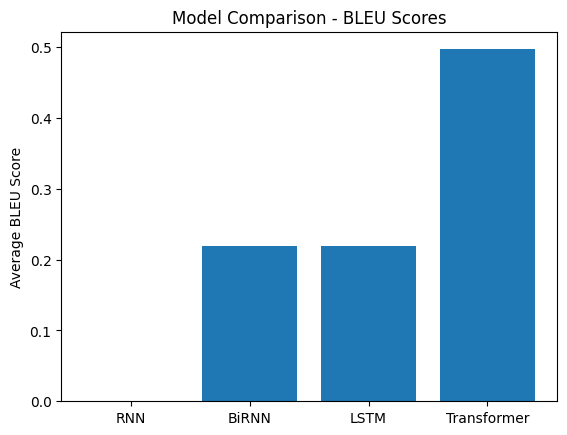

In [29]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt

# Function to convert sequences of indices back to text
def sequence_to_text(sequence, tokenizer):
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
    return ' '.join([reverse_word_map.get(idx, '') for idx in sequence if idx != 0])

# Function to evaluate a model
def evaluate_model(model, X_test, y_test, decoder_input_test, en_tokenizer, ur_tokenizer, model_name):
    predicted_seq = model.predict([X_test, decoder_input_test])
    predicted_seq = np.argmax(predicted_seq, axis=-1)

    bleu_scores = []
    print(f"\n--- {model_name} Evaluation ---\n")

    for i in range(5):
        # Get the English input, reference, and predicted translation
        eng = sequence_to_text(X_test[i], en_tokenizer)
        ref = sequence_to_text(y_test[i].flatten(), ur_tokenizer)
        hyp = sequence_to_text(predicted_seq[i], ur_tokenizer)

        # Print the translations
        print(f" English   : {eng}")
        print(f" Reference : {ref}")
        print(f" Predicted : {hyp}")

        # Calculate BLEU score for this sentence
        bleu_score = sentence_bleu([ref.split()], hyp.split())
        bleu_scores.append(bleu_score)
        print(f" BLEU Score: {bleu_score}\n")

    # Calculate the average BLEU score for the model
    avg_bleu_score = np.mean(bleu_scores)
    print(f"--- {model_name} Average BLEU Score: {avg_bleu_score} ---\n")
    return avg_bleu_score

# Model evaluation
bleu_rnn = evaluate_model(rnn_model, X_test, y_test, decoder_input_test, en_tokenizer, ur_tokenizer, "RNN")
bleu_birnn = evaluate_model(rnn_model_birnn, X_test, y_test, decoder_input_test, en_tokenizer, ur_tokenizer, "BiRNN")
bleu_lstm = evaluate_model(lstm_model, X_test, y_test, decoder_input_test, en_tokenizer, ur_tokenizer, "LSTM")
bleu_transformer = evaluate_model(transformer_model, X_test, y_test, decoder_input_test, en_tokenizer, ur_tokenizer, "Transformer")

# Plotting BLEU scores
bleu_scores = {
    'RNN': bleu_rnn,
    'BiRNN': bleu_birnn,
    'LSTM': bleu_lstm,
    'Transformer': bleu_transformer,
}

# Plotting the BLEU scores for comparison
plt.bar(bleu_scores.keys(), bleu_scores.values())
plt.ylabel('Average BLEU Score')
plt.title('Model Comparison - BLEU Scores')
plt.show()


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Function to convert sequences of indices back to text
def sequence_to_text(sequence, tokenizer):
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
    return ' '.join([reverse_word_map.get(idx, '') for idx in sequence if idx != 0])

# Evaluation function with BLEU + smoothing
def evaluate_model(model, X_test, y_test, decoder_input_test, en_tokenizer, ur_tokenizer, model_name):
    predicted_seq = model.predict([X_test, decoder_input_test])
    predicted_seq = np.argmax(predicted_seq, axis=-1)

    bleu_scores = []
    smoothing = SmoothingFunction().method1

    print(f"\n---  {model_name} Evaluation ---\n")

    for i in range(5):  # Show 5 examples
        eng = sequence_to_text(X_test[i], en_tokenizer)
        ref = sequence_to_text(y_test[i].flatten(), ur_tokenizer)
        hyp = sequence_to_text(predicted_seq[i], ur_tokenizer)

        print(f" English   : {eng}")
        print(f" Reference : {ref}")
        print(f" Predicted : {hyp}")

        # BLEU score with smoothing
        bleu_score = sentence_bleu([ref.split()], hyp.split(), smoothing_function=smoothing)
        bleu_scores.append(bleu_score)
        print(f" BLEU Score: {bleu_score:.4f}\n")

    avg_bleu_score = np.mean(bleu_scores)
    print(f" --- {model_name} Average BLEU Score: {avg_bleu_score:.4f} ---\n")
    return avg_bleu_score


In [32]:
bleu_rnn = evaluate_model(rnn_model, X_test, y_test, decoder_input_test, en_tokenizer, ur_tokenizer, "RNN")
bleu_birnn = evaluate_model(rnn_model_birnn, X_test, y_test, decoder_input_test, en_tokenizer, ur_tokenizer, "BiRNN")
bleu_lstm = evaluate_model(lstm_model, X_test, y_test, decoder_input_test, en_tokenizer, ur_tokenizer, "LSTM")
bleu_transformer = evaluate_model(transformer_model, X_test, y_test, decoder_input_test, en_tokenizer, ur_tokenizer, "Transformer")


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

---  RNN Evaluation ---

 English   : he can no longer wait
 Reference : وہ مزید انتظار نہیں کر سکتا
 Predicted : ایک نہیں کر کر رہا
 BLEU Score: 0.0930

 English   : what is zain drinking
 Reference : زین پینے کیا ہے
 Predicted : نے کے پسند
 BLEU Score: 0.0000

 English   : dont burst my bubble
 Reference : میرا بلبلا مت پھٹاؤ
 Predicted : نام ہے پڑھو
 BLEU Score: 0.0000

 English   : are you still married
 Reference : کیا آپ اب بھی شادی شدہ ہیں
 Predicted : آپ نے بھی وہاں کر ہیں
 BLEU Score: 0.0455

 English   : i will come back later
 Reference : میں بعد میں واپس آؤں گا
 Predicted : نے میں آپ آؤں گا۔
 BLEU Score: 0.0523

 --- RNN Average BLEU Score: 0.0382 ---

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

---  BiRNN Evaluation ---

 English   : he can no longer wait
 Reference : وہ مزید انتظار نہیں کر سکتا
 Predicted : اب انتظار نہیں کر سکتا
 BLEU Score: 0.5475

 English   : what is zain drinking
 Reference : زین پینے کیا ہے
 Predicted : کیا کیا ہے

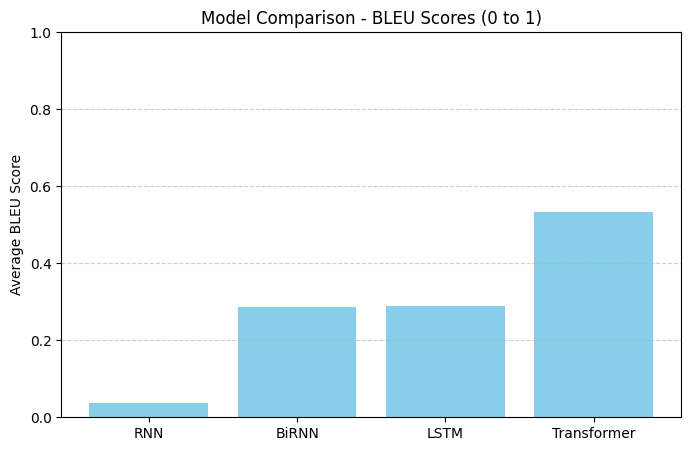

In [33]:
# Store BLEU scores
bleu_scores = {
    'RNN': bleu_rnn,
    'BiRNN': bleu_birnn,
    'LSTM': bleu_lstm,
    'Transformer': bleu_transformer,
}

# Plot BLEU scores
plt.figure(figsize=(8, 5))
plt.bar(bleu_scores.keys(), bleu_scores.values(), color='skyblue')
plt.ylim(0, 1)
plt.ylabel('Average BLEU Score')
plt.title('Model Comparison - BLEU Scores (0 to 1)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


# QUESTION 4

In [ ]:
#USE THE ABOVE SIMPLE RNN CODE

In [ ]:
import numpy as np

# Load GloVe embeddings (using 100d version)
embedding_index = {}
with open("/content/glove.6B.100d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print("Loaded %s word vectors from GloVe." % len(embedding_index))

Loaded 400000 word vectors from GloVe.


In [ ]:
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((en_vocab_size, EMBEDDING_DIM))

for word, i in en_tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Input
from tensorflow.keras.models import Model

def build_rnn_with_glove():
    # Encoder with GloVe embeddings
    encoder_inputs = Input(shape=(MAX_LEN_EN,))
    encoder_embedding = Embedding(en_vocab_size, EMBEDDING_DIM,
                                  weights=[embedding_matrix],
                                  trainable=False)(encoder_inputs)
    encoder_output, state = SimpleRNN(128, return_state=True)(encoder_embedding)

    # Decoder with trainable embeddings
    decoder_inputs = Input(shape=(MAX_LEN_UR,))
    decoder_embedding = Embedding(ur_vocab_size, 128)(decoder_inputs)
    decoder_output = SimpleRNN(128, return_sequences=True)(decoder_embedding, initial_state=state)
    outputs = Dense(ur_vocab_size, activation='softmax')(decoder_output)

    model = Model([encoder_inputs, decoder_inputs], outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

rnn_model_glove = build_rnn_with_glove()
rnn_model_glove.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_14        │ (None, 20, 100)   │    567,900 │ input_layer_14[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_15        │ (None, 20, 128)   │    759,040 │ input_layer_15[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_14       │ [(None, 128),     │     29,312 │ embedding_14[0][… │
│ (SimpleRNN)         │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_15       │ (None, 20, 128)   │     32,896 │ embedding_15[0][… │
│ (SimpleRNN)         │                   │            │ simple_rnn_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 20, 5930)  │    764,970 │ simple_rnn_15[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,154,118 (8.22 MB)

 Trainable params: 1,586,218 (6.05 MB)

 Non-trainable params: 567,900 (2.17 MB)

In [ ]:
decoder_input_data_glove = y_train[:, :-1]
decoder_input_data_glove = pad_sequences(decoder_input_data_glove, maxlen=MAX_LEN_UR, padding='post')

decoder_target_data_glove = y_train[:, 1:]
decoder_target_data_glove = pad_sequences(decoder_target_data_glove, maxlen=MAX_LEN_UR, padding='post')

In [ ]:
history_glove = rnn_model_glove.fit(
    [X_train, decoder_input_data_glove],
    decoder_target_data_glove,
    epochs=50,
    batch_size=64,
    validation_split=0.1
)

Epoch 1/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.7773 - loss: 2.9578 - val_accuracy: 0.8089 - val_loss: 1.2141
Epoch 2/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8135 - loss: 1.1771 - val_accuracy: 0.8211 - val_loss: 1.1187
Epoch 3/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8252 - loss: 1.0620 - val_accuracy: 0.8291 - val_loss: 1.0470
Epoch 4/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8352 - loss: 0.9699 - val_accuracy: 0.8371 - val_loss: 0.9904
Epoch 5/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8436 - loss: 0.8980 - val_accuracy: 0.8413 - val_loss: 0.9518
Epoch 6/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8491 - loss: 0.8421 - val_accuracy: 0.8447 - val_loss: 0.9279
Epoch 7/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8550 - loss: 0.7917 - val_accuracy: 0.8462 - val_loss: 0.9114
Epoch 8/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8574 - loss: 0.7589 - val_acc

In [ ]:
# Prepare decoder input for test data
decoder_input_test = y_test[:, :-1]
decoder_input_test = pad_sequences(decoder_input_test, maxlen=MAX_LEN_UR, padding='post')

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def sequence_to_text(sequence, tokenizer):
    reverse_word_index = dict((i, word) for word, i in tokenizer.word_index.items())
    if isinstance(sequence[0], (list, np.ndarray)):
        sequence = sequence[0]
    return ' '.join([reverse_word_index.get(int(idx), '') for idx in sequence if idx != 0])

def evaluate_model(model, X_test, y_test, decoder_input_test, en_tokenizer, ur_tokenizer, model_name, sample_size=5):
    predicted_seq = model.predict([X_test[:sample_size], decoder_input_test[:sample_size]])
    predicted_seq = np.argmax(predicted_seq, axis=-1)

    bleu_scores = []
    print(f"\n--- {model_name} Evaluation (on {sample_size} samples) ---\n")

    for i in range(sample_size):
        eng = sequence_to_text(X_test[i], en_tokenizer)
        ref = sequence_to_text(y_test[i].flatten(), ur_tokenizer)
        hyp = sequence_to_text(predicted_seq[i], ur_tokenizer)

        print(f" English   : {eng}")
        print(f" Reference : {ref}")
        print(f" Predicted : {hyp}")

        smoothie = SmoothingFunction().method4
        bleu_score = sentence_bleu([ref.split()], hyp.split(), smoothing_function=smoothie)
        bleu_scores.append(bleu_score)
        print(f" BLEU Score: {bleu_score:.4f}\n")

    avg_bleu_score = np.mean(bleu_scores)
    print(f"--- {model_name} Average BLEU Score (on {sample_size} samples): {avg_bleu_score:.4f} ---\n")
    return avg_bleu_score


In [ ]:
# Evaluate vanilla RNN model
avg_bleu_rnn = evaluate_model(
    rnn_model, X_test, y_test, decoder_input_test, en_tokenizer, ur_tokenizer,
    model_name="Vanilla RNN"
)

# Evaluate RNN with GloVe
avg_bleu_glove = evaluate_model(
    rnn_model_glove, X_test, y_test, decoder_input_test, en_tokenizer, ur_tokenizer,
    model_name="RNN with GloVe Embeddings"
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step

--- Vanilla RNN Evaluation (on 5 samples) ---

 English   : he can no longer wait
 Reference : وہ مزید انتظار نہیں کر سکتا
 Predicted : اب مذاق نہیں کرتے سکتے
 BLEU Score: 0.0374

 English   : what is zain drinking
 Reference : زین پینے کیا ہے
 Predicted : کیا کے
 BLEU Score: 0.0248

 English   : dont burst my bubble
 Reference : میرا بلبلا مت پھٹاؤ
 Predicted : انتظار مت توڑو
 BLEU Score: 0.0519

 English   : are you still married
 Reference : کیا آپ اب بھی شادی شدہ ہیں
 Predicted : آپ اب بھی یہاں ہیں؟ ہے؟
 BLEU Score: 0.1979

 English   : i will come back later
 Reference : میں بعد میں واپس آؤں گا
 Predicted : اس میں واپس آؤں گا۔
 BLEU Score: 0.2452

--- Vanilla RNN Average BLEU Score (on 5 samples): 0.1115 ---



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step

--- RNN with GloVe Embeddings Evaluation (on 5 samples) ---

 English   : he can no longer wait
 Reference : وہ مزید انتظار نہیں کر سکتا
 Predicted : اس نہیں کر کرتا سکتے
 BLEU Score: 0.0992

 English   : what is zain drinking
 Reference : زین پینے کیا ہے
 Predicted : نے کے چاہتا
 BLEU Score: 0.0000

 English   : dont burst my bubble
 Reference : میرا بلبلا مت پھٹاؤ
 Predicted : مطلب کہاں جاؤ
 BLEU Score: 0.0000

 English   : are you still married
 Reference : کیا آپ اب بھی شادی شدہ ہیں
 Predicted : آپ کے بھی یہاں شدہ ہے؟
 BLEU Score: 0.0419

 English   : i will come back later
 Reference : میں بعد میں واپس آؤں گا
 Predicted : نے میں آپ آؤں گا۔
 BLEU Score: 0.0444

--- RNN with GloVe Embeddings Average BLEU Score (on 5 samples): 0.0371 ---



In [ ]:
print(" Final BLEU Score Comparison:")
print(f"Vanilla RNN         : {avg_bleu_glove:.4f}")
print(f"RNN with GloVe      : {avg_bleu_rnn:.4f}")

if avg_bleu_glove > avg_bleu_rnn:
    print(" GloVe embeddings improved the translation quality!")
else:
    print(" GloVe embeddings didn't help in this case or more tuning is needed.")


 Final BLEU Score Comparison:
Vanilla RNN         : 0.0371
RNN with GloVe      : 0.1115
 GloVe embeddings didn't help in this case or more tuning is needed.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

--- Vanilla RNN Evaluation (on 5 samples) ---

 English   : he can no longer wait
 Reference : وہ مزید انتظار نہیں کر سکتا
 Predicted : اب مذاق نہیں کرتے سکتے
 BLEU Score: 0.0374

 English   : what is zain drinking
 Reference : زین پینے کیا ہے
 Predicted : کیا کے
 BLEU Score: 0.0248

 English   : dont burst my bubble
 Reference : میرا بلبلا مت پھٹاؤ
 Predicted : انتظار مت توڑو
 BLEU Score: 0.0519

 English   : are you still married
 Reference : کیا آپ اب بھی شادی شدہ ہیں
 Predicted : آپ اب بھی یہاں ہیں؟ ہے؟
 BLEU Score: 0.1979

 English   : i will come back later
 Reference : میں بعد میں واپس آؤں گا
 Predicted : اس میں واپس آؤں گا۔
 BLEU Score: 0.2452

--- Vanilla RNN Average BLEU Score (on 5 samples): 0.1115 ---

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

--- RNN with GloVe Evaluation (on 5 samples) ---

 English   : he can no longer wait
 Reference : وہ مزید انتظار نہیں کر سکتا
 Predicted : اس نہیں کر کرتا سکتے
 BLEU Score: 0.0992

 English   : what

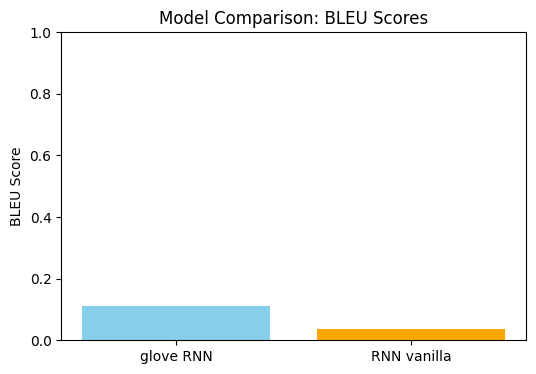

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the scores returned like this
bleu_rnn = evaluate_model(rnn_model, X_test, y_test, decoder_input_test, en_tokenizer, ur_tokenizer, "Vanilla RNN", sample_size=5)
bleu_glove = evaluate_model(rnn_model_glove, X_test, y_test, decoder_input_test, en_tokenizer, ur_tokenizer, "RNN with GloVe", sample_size=5)

plt.figure(figsize=(6, 4))
plt.bar(["glove RNN", "RNN vanilla"], [bleu_rnn, bleu_glove], color=["skyblue", "orange"])
plt.ylabel("BLEU Score")
plt.title("Model Comparison: BLEU Scores")
plt.ylim(0, 1)
plt.show()
